# An Example of Using Instrumental Variables to Estimate Price Elasticities
Author: Matt Birch

Initial Post: 06/20/2022

Objective: demonstrate a common concern in estimating price elasticities and how Instrumental Variables (IV) can alleviate it. 

Note: This model is simplistic, but can be easily generalized to more complex scenarios.

# Introduction
This is the code for my video  on instrumental variables: https://youtu.be/fpZC_tEfnLM 

I want to give a little background. My scenario here originates from Kathryn Graddy's awesome 2006 work  on the Fulton Fish Market: https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207

To oversimplify her paper, Graddy was interested in determining the extent of market power within that market. Part of this is estimating price elasticities of demand. These elasticities are an economic measure of consumers' responsiveness to price changes. Sellers with market power can charge higher prices to customers with inelastic demand than those with elastic demand, as they are more rigid and less sensitive to price changes. Read the paper: she does cool stuff!

I am going to use her data and framework to demonstrate the "Instrumental Variables" technique and demonstrate how it is useful in estimating elasticities in markets with supply and demand. 

# Preliminaries

In [1]:
# elt
import pandas as pd
import numpy as np

# ols and iv models
import statsmodels.api as sm
from linearmodels import IV2SLS 

#visualization and animation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display


# Import data
I found the Fulton data here on Kathryn Graddy's webpage: https://people.brandeis.edu/~kgraddy/datasets/fish.out
I saved it to a ".txt" file for future use. 

In [2]:
fulton_data = pd.read_csv("fulton_fish_market_data.txt", sep = '\t')
fulton_data

,day1,day2,day3,day4,date,stormy,mixed,price,qty,rainy,cold,windspd,windspd2,pricelevel,totr,tots
0,1,0,0,0,911202,1,0,-0.430783,8.994421,1,0,2.995732,8.974412,0.650000,7232,8058
1,0,1,0,0,911203,1,0,0.000000,7.707063,0,0,2.995732,8.974412,1.000000,2110,2224
2,0,0,1,0,911204,0,1,0.072321,8.350194,1,1,2.813411,7.915280,1.075000,5247,4231
3,0,0,0,1,911205,1,0,0.247139,8.656955,0,1,3.036554,9.220662,1.280357,1290,5750
4,0,0,0,0,911206,1,0,0.664327,7.844241,0,1,3.036554,9.220662,1.943182,1717,2551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,0,0,0,920504,0,0,-0.798508,8.610683,0,0,2.862201,8.192194,0.450000,1610,6260
107,0,1,0,0,920505,0,1,-0.087011,7.162397,0,0,2.908721,8.460658,0.916667,1320,1290
108,0,0,1,0,920506,0,1,0.184922,7.362010,0,0,2.862201,8.192194,1.203125,2305,1450
109,0,0,0,1,920507,0,1,0.223143,8.764053,0,0,2.813411,7.915280,1.250000,6080,4780


In [3]:
fulton_data.isnull().sum()

day1          0
day2          0
day3          0
day4          0
date          0
stormy        0
mixed         0
price         0
qty           0
rainy         0
cold          0
windspd       0
windspd2      0
pricelevel    0
totr          0
tots          0
dtype: int64

### A few observations and more elasticity stuff.
First things first: this is a clean data set, already ready to use. (sweet!)
We have information on days of the week, dates, weather info, and price and quantity info. The variables "price" and "qty" are actually logged variables, ln(price) and ln(quantity). In a linear model of ln(quantity) regressed onto ln(price), the coefficient on ln(price) is interpreted as "percent change in quantity divided by percent change in price," which is the price elasticity of demand.

### A note on r-squared values and predictive power:
These models will be overly simplistic and will have little predicitve power. The purpose of this document is not to accurately predict market quantities, but to demonstrate why accounting for endogenous features is important. I will be using some regression plots to make my case, and this simplified model communicates the necessary information without making the plots cumbersome.

# Problem: price and quantity are endogenous
Here is a little plot of the data points that went in to this model

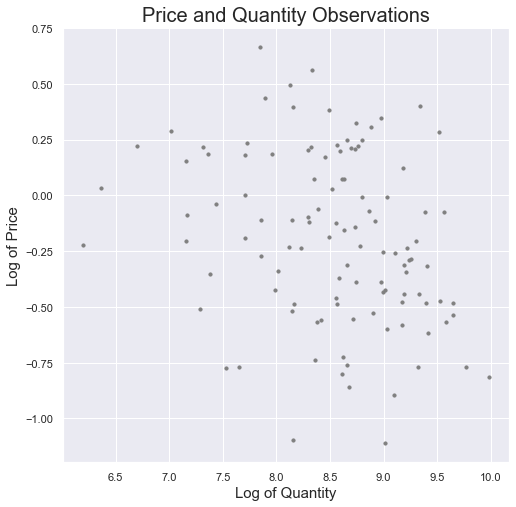

In [16]:
sns.set()
fig_static = plt.figure(figsize = (8,8))
plt.scatter(fulton_data['qty'],fulton_data['price'], s = 10, c = 'gray')
plt.ylabel('Log of Price', fontsize = 15)
plt.xlabel('Log of Quantity', fontsize = 15)
plt.title('Price and Quantity Observations', fontsize = 20)
plt.show()

Sadly, we can't just plot a regression through these and assume it highlights a demand curve.  This is something economists get really picky about. Because price and quantity are chosen simultaneously by supply and demand, we would be estimating demand, but based off of points that capture supply AND demand. The error terms will not be random, with my price feature being uncorrelated with the error term. Nope. We call it endogenous, which means our coefficient will be determined within the model, and will biased and untrustworthy. That is why we need instrumental variables. 

But first, let me explain this supply and demand stuff with a couple of graphs:

# Starting with supply shifting

If supply changes and demand stays still, we can observe price-quantity pairs on the same demand curve, as in the graph below. (Warning: I did some simple supply and demand calculations to make the graph. You may skip to the graph to see how supply can change price and quantity. 

In [5]:
#setting up some arbitrary supply and demand parameters
sup_shift = np.array([[0,.5],[1,.5],[2,.5]])
dem0 = np.array([5,.5])
n_eqs = len(sup_shift[:,0])
#Setting up supply and demand curves on approptiate arbitrary interval
x = np.linspace(0,7,100)
d = dem0[0] - dem0[1]*x
s0 = sup_shift[0,0] + sup_shift[0,1]*x
s1 = sup_shift[1,0] + sup_shift[1,1]*x
s2 = sup_shift[2,0] + sup_shift[2,1]*x

#solving for equilibrium price and quantity at each demand level
q_sup_shift = (dem0[0]-sup_shift[:,0])/(dem0[1]+sup_shift[:,1])
p_sup_shift = (sup_shift[:,0]+sup_shift[:,1]*q_sup_shift[:])
q_sup_shift.reshape(n_eqs,1)
p_sup_shift.reshape(n_eqs,1)

array([[2.5],
       [3. ],
       [3.5]])

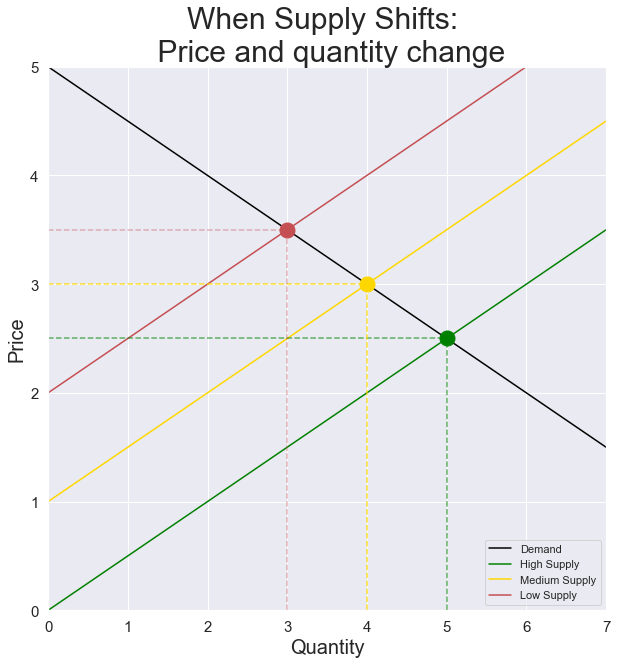

In [6]:
Supply_Shift = plt.figure(figsize = (10,10))

# plot main lines
plt.plot(x,d, color = 'black', label = 'Demand')
plt.plot(x,s0, color = 'green', label = 'High Supply')
plt.plot(x,s1, color = 'gold', label = 'Medium Supply')
plt.plot(x,s2, color = 'r', label = 'Low Supply')

# price lines
plt.plot([0,q_sup_shift[0]],[p_sup_shift[0],p_sup_shift[0]], color = 'green', linestyle = '--', alpha = 0.6)
plt.plot([0,q_sup_shift[1]],[p_sup_shift[1],p_sup_shift[1]], color = 'gold', linestyle = '--', alpha = 0.8)
plt.plot([0,q_sup_shift[2]],[p_sup_shift[2],p_sup_shift[2]], color = 'r', linestyle = '--', alpha = 0.4)

# quantity lines
plt.plot([q_sup_shift[0],q_sup_shift[0]],[0,p_sup_shift[0]], color = 'green', linestyle = '--', alpha = 0.6)
plt.plot([q_sup_shift[1],q_sup_shift[1]],[0,p_sup_shift[1]], color = 'gold', linestyle = '--', alpha = 0.8)
plt.plot([q_sup_shift[2],q_sup_shift[2]],[0,p_sup_shift[2]], color = 'r', linestyle = '--', alpha = 0.4)

# equilibrium dots
plt.plot(q_sup_shift[0],p_sup_shift[0], 'o', markersize = 15, color = 'green')
plt.plot(q_sup_shift[1],p_sup_shift[1], 'o', markersize = 15, color = 'gold')
plt.plot(q_sup_shift[2],p_sup_shift[2], 'o', markersize = 15, color = 'r')

# labels and other boring stuff
plt.xlabel('Quantity', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.title('When Supply Shifts: \n Price and quantity change', fontsize = 30)
plt.xlim([0,7])
plt.ylim([0,5])
plt.legend(loc = 'lower right')
plt.tick_params(labelsize = 15)

plt.show()

Note 1: In the graph above, the different price quantity pairs exist because of different supply curves along the same demand curve. We would love for this to be the only source of variation in price and quantity when estimating demand. No such luck, though.

Note 2: This graph actually shows inverse demand curves and an inverse supply curve where price is a function of quantity. We are estimating the demand curve where quantity is a function of price, so the axes are flipped between this graph and the regression plot. The default setting in "drawing" supply and demand curves is inverse curves, even if we estimate the regular curves. I don't know why we do it that way, but yeah. Heads up on your axis labels!

# What if demand moves?

If that last graph were the only way price and quantity could move, we would be all set and OLS would be all we need. Unfortunately for us, the demand curve can also change over time, even if supply is constant. Below I will graphically demonstrate how demand shifts can also affect price-wuantity pairings, thereby breaking our confidence in the elasticity estimate from the OLS output. I have more supply and demand calculations below. Go ahead and skip to the graph if you are not interested in that. 

In [7]:
#setting up some arbitrary supply and demand parameters
dem_shift = np.array([[5,.5],[4,.5],[3,.5]])
sup0 = np.array([1,.5])

#Setting up supply and demand curves on approptiate arbitrary interval
x = np.linspace(0,7,100)
s = sup0[0] + sup0[1]*x
d0 = dem_shift[0,0] - dem_shift[0,1]*x
d1 = dem_shift[1,0] - dem_shift[1,1]*x
d2 = dem_shift[2,0] - dem_shift[2,1]*x

#solving for equilibrium price and quantity at each demand level
q_dem_shift = ((dem_shift[:,0]-sup0[0])/(dem_shift[:,1]+sup0[1]))
p_dem_shift = (dem_shift[:,0]-dem_shift[:,1]*q_dem_shift[:])
q_dem_shift.reshape(n_eqs,1)
p_dem_shift.reshape(n_eqs,1)
q_dem_shift[0]

4.0

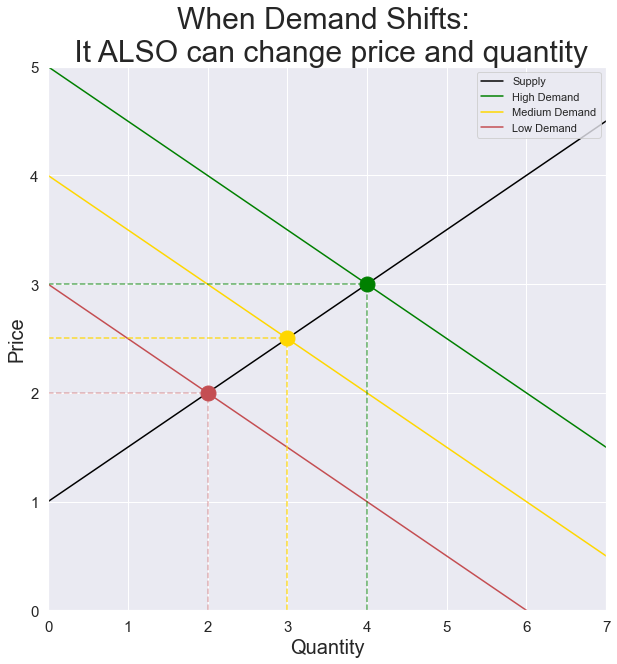

In [8]:
Demand_Shift = plt.figure(figsize = (10,10))

# plot main lines
plt.plot(x,s, color = 'black', label = 'Supply')
plt.plot(x,d0, color = 'green', label = 'High Demand')
plt.plot(x,d1, color = 'gold', label = 'Medium Demand')
plt.plot(x,d2, color = 'r', label = 'Low Demand')

# price lines
plt.plot([0,q_dem_shift[0]],[p_dem_shift[0],p_dem_shift[0]], color = 'green', linestyle = '--', alpha = 0.6)
plt.plot([0,q_dem_shift[1]],[p_dem_shift[1],p_dem_shift[1]], color = 'gold', linestyle = '--', alpha = 0.8)
plt.plot([0,q_dem_shift[2]],[p_dem_shift[2],p_dem_shift[2]], color = 'r', linestyle = '--', alpha = 0.4)

# quantity lines
plt.plot([q_dem_shift[0],q_dem_shift[0]],[0,p_dem_shift[0]], color = 'green', linestyle = '--', alpha = 0.6)
plt.plot([q_dem_shift[1],q_dem_shift[1]],[0,p_dem_shift[1]], color = 'gold', linestyle = '--', alpha = 0.8)
plt.plot([q_dem_shift[2],q_dem_shift[2]],[0,p_dem_shift[2]], color = 'r', linestyle = '--', alpha = 0.4)

# equilibrium dots
plt.plot(q_dem_shift[0],p_dem_shift[0], 'o', markersize = 15, color = 'green')
plt.plot(q_dem_shift[1],p_dem_shift[1], 'o', markersize = 15, color = 'gold')
plt.plot(q_dem_shift[2],p_dem_shift[2], 'o', markersize = 15, color = 'r')

# labels and other boring stuff
plt.xlabel('Quantity', fontsize = 20)
plt.ylabel('Price', fontsize = 20)
plt.title('When Demand Shifts: \n It ALSO can change price and quantity', fontsize = 30)
plt.xlim([0,7])
plt.ylim([0,5])
plt.legend(loc = 'upper right')
plt.tick_params(labelsize = 15)

plt.show()

### Take away:
Demand can move, supply can move, and both can move simultaneously. These graphs are not meant to be a comprehensive treatment of supply and demand analysis, but they do show us that the price-quantity pairings in our data cannot be assumed to be limited to only demand information.

# Linear regression
Let's start with the linear regression model, even if we don't really trust it. We'll compare these results to the IV output below and see how this might affect our understanding of the market. 

In [9]:
#standard Python syntax using statsmodels package
x = fulton_data ['price']
x = sm.add_constant(x)
y = fulton_data['qty']

ols = sm.OLS(y,x).fit()
ols.summary()

# or this code allows you to use r syntax in model
# ols_r = sm.OLS.from_formula("qty ~ price", data = fulton_data).fit()
# ols_r.summary()

C:\Users\mbirch\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    qty   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.167
Date:                Mon, 20 Jun 2022   Prob (F-statistic):            0.00308
Time:                        13:41:05   Log-Likelihood:                -119.35
No. Observations:                 111   AIC:                             242.7
Df Residuals:                     109   BIC:                             248.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4187      0.076    110.445      0.000       8.268       8.570
price         -0.5409      0.179     -3.028      0.003      -0.895      -0.187
==============================================================================
Omnibus:                       12.064   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.644
Skew:                          -0.796   Prob(JB):                      0.00180
Kurtosis:                       3.448   Cond. No.                         2.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# So on to instrumental variables!

In [10]:
iv_reg = IV2SLS.from_formula("qty ~ 1 + [price ~ stormy]", fulton_data).fit()
iv_reg.summary
# the one is the regression intercept and you can include more features in the model, too.

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    qty   R-squared:                     -0.0002
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0094
No. Observations:                 111   F-statistic:                    5.2772
Date:                Mon, Jun 20 2022   P-value (F-stat)                0.0216
Time:                        13:41:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      8.3138     0.1175     70.750     0.0000      8.0835      8.5441
price         -1.0824     0.4712    -2.2972     0.0216     -2.0059     -0.1589
==============================================================================

Endogenous: price
Instruments: stormy
Robust Covariance (Heteroskedastic)
Debiased: False
"""

# Visualization of these two regressions

In [11]:
# storing regression coefficients
b = ols.params
b2 = iv_reg.params

# creating endpoint x values for both regression lines
low = -1.25
high = 0.75
x_vals = [low,high]

# creating endpoint y values of regression line
ols_ly = b[0] + low*b[1]
ols_ry = b[0] + high*b[1]
ols_ys = [ols_ly, ols_ry]

iv_ly = b2[0] + low*b2[1]
iv_ry = b2[0] + high*b2[1]
iv_ys = [iv_ly, iv_ry]

I am going to animate these regressions and show how much the OLS output has to change to match the IV output. This will effectively show us, visually, how "wrong" OLS was for this situation (at least as far as we can tell). 

In [12]:
# create increments between the regression lines so that I can create the gradual change between them.
num_y = 100
y_left_step = (iv_ly-ols_ly)/(num_y-1)
y_right_step =(iv_ry-ols_ry)/(num_y-1)

y_left_loop = []
y_right_loop = []
for i in range(0,num_y):
    y_left_loop.append(round(ols_ly+i*y_left_step,2))
    y_right_loop.append(round(ols_ry+i*y_right_step,2))

In [13]:
#the left column show the progression from left point iv to left point ols
# the right column shows progression on right from right ols to right iv
y_left = np.array(y_left_loop).reshape(num_y,1)
y_right = np.array(y_right_loop).reshape(num_y,1)
ys = np.hstack([y_left,y_right])

# Animated graph

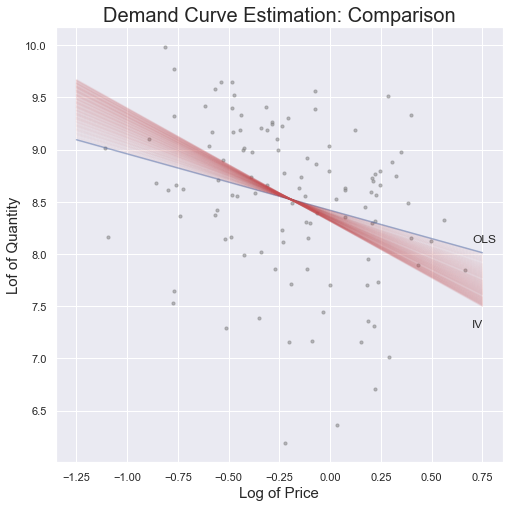

In [14]:
fig = plt.figure(figsize = (8,8))
plt.scatter(fulton_data['price'],fulton_data['qty'], s = 10, alpha = 0.5, c = 'gray')
plt.xlabel('Log of Price', fontsize = 15)
plt.ylabel('Log of Quantity', fontsize = 15)
ols = plt.plot(x_vals, ols_ys, color = 'b', label = 'OLS', alpha = 0.5)
#iv = plt.plot(x_vals, iv_ys, color = 'r', label = 'IV', alpha = 0.5)
plt.text(high-.05,iv_ry -.2, "IV")
plt.text(high-.05,ols_ry+.1, "OLS")
plt.title('Demand Curve Estimation: Comparison', fontsize = 20)

#plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'
#Writer = matplotlib.animation.writers['ffmpeg']

def animate_1(i):
    return plt.plot(x_vals, [y_left_loop[i],y_right_loop[i]], color = 'r', label = 'IV', alpha = 0.02+(0.15*i/(1.5*num_y)))
vid = FuncAnimation(fig = fig, func = animate_1, interval = 50, frames = num_y)


video = vid.to_html5_video()
html = display.HTML(video)
display.display(html)

#Note that if you run this in your own Jupyter notebook, this graph will be animated. 



# Here is a static representation of these regressions. 

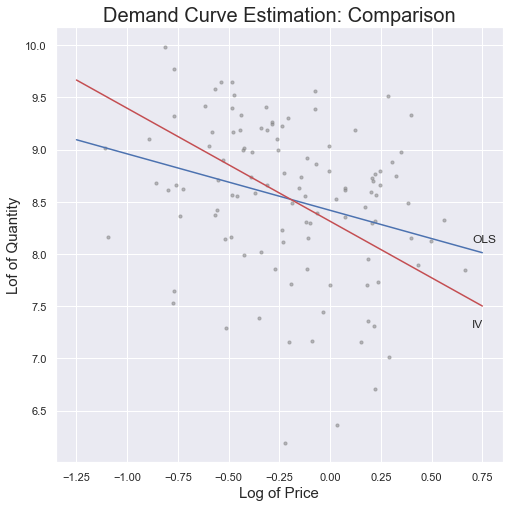

In [15]:
fig_static = plt.figure(figsize = (8,8))
plt.scatter(fulton_data['price'],fulton_data['qty'], s = 10, alpha = 0.5, c = 'gray')
plt.xlabel('Log of Price', fontsize = 15)
plt.ylabel('Log of Quantity', fontsize = 15)
ols = plt.plot(x_vals, ols_ys, color = 'b', label = 'OLS')
iv = plt.plot(x_vals, iv_ys, color = 'r', label = 'IV')
plt.text(high-.05,iv_ry -.2, "IV")
plt.text(high-.05,ols_ry+.1, "OLS")
plt.title('Demand Curve Estimation: Comparison', fontsize = 20)
plt.show()

# Who cares?!

Consider this: if you want to choose the price of your product, or if you want to know who to advertise to, or any number of other important business decisions, you need to know about your market elasticity. If I were in this market, and I thought my demand looked like the OLS demand (which is wrong), I would choose a higher than optimal price mark-up which would drive away too many customers and yeild lower profit than if I based my decisions off of the IV demand. That would be lame!

Anyone who makes choices related to customer wellbeing or business profit maximization should be interested in estimating properly. 